In [67]:
import IPython.core.debugger as pdb

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

In [20]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label=f"{{{n.label} | data {n.data:.4f} | grad {n.grad:.4f}}}",
            shape="record",
        )
        if n._op:
            # if the node is a result of some operation create an op node for it.
            dot.node(name=uid + n._op, label=f"{n._op}")
            # connect this node to it.
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node for n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [162]:
class Value:
    def __init__(self, data, _children=(), _op=None, label=""):
        self.data = data
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (float, int)), "only support int/float"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * (self.data ** (other - 1.0))) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2.0 * x) - 1.0) / (math.exp(2.0 * x) + 1.0)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1.0 - out.data**2.0) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

    def __truediv__(self, other):
        return self * other**-1

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __repr__(self):
        return f"Value(data={self.data})"

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * (-1)


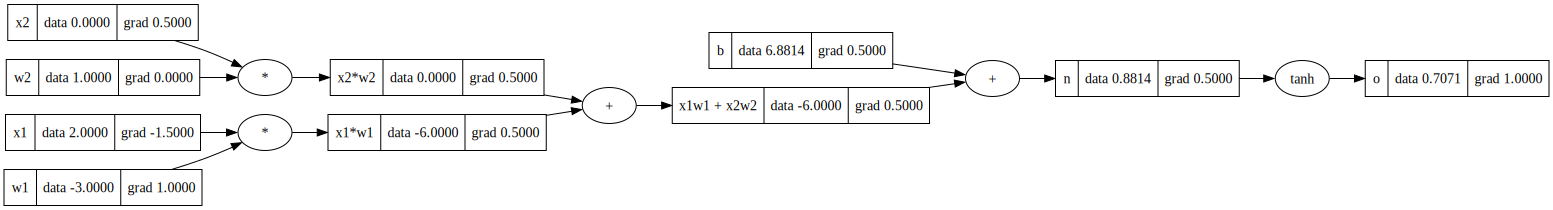

In [163]:
# prepare a simple neural net.
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n.label = "n"
# --------
o = n.tanh()
# --------
o.label = "o"
o.backward()
draw_dot(o)

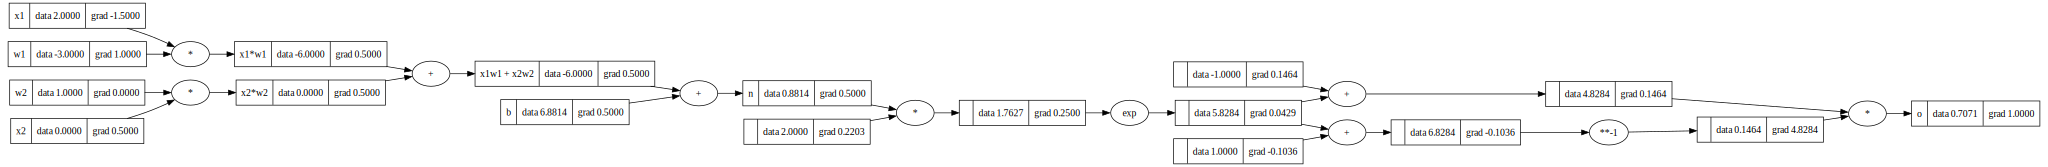

In [164]:
# prepare a simple neural net.
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias

b = Value(6.8813735, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n.label = "n"
# --------
e = (2*n).exp()
o = (e-1)/(e+1)
# --------
o.label = "o"
o.backward()
draw_dot(o)

In [165]:
# implementing this in pytorch
import torch

x1 = torch.tensor([2.0]).double()                    ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()                    ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()                   ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()                    ; w2.requires_grad = True
b = torch.tensor([6.8813735]).double()               ; b.requires_grad = True
n = w1*x1 + w2*x2 + b

o = torch.tanh(n)
print(o.data.item())
o.backward()
print("-----")
print(f"x1:{x1.grad.item()}")
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('b', b.grad.item())

0.7071066904050358
-----
x1:-1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0
b 0.5000001283844369


In [166]:
import random

In [196]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))    
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), start = self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        return params
        

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params

In [310]:
x = [2.0, 3.0, 4.0]

n = MLP(3, [2,3,1])

n(x)

Value(data=0.03207414987804689)

In [311]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]]
ys = [1.0,-1.0, -1.0, 1.0]

In [326]:
for k in range(100):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
    
    #backward pass
    
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    # update weights
    h = 0.1
    for p in n.parameters():
        p.data += -p.grad * h
        
    print(k, loss.data)

0 0.0008175338294519175
1 0.0008155917064608803
2 0.0008136586103530222
3 0.0008117344788589677
4 0.000809819250278031
5 0.000807912863471752
6 0.0008060152578575417
7 0.0008041263734023983
8 0.0008022461506166784
9 0.0008003745305480288
10 0.0007985114547753198
11 0.0007966568654026942
12 0.0007948107050537228
13 0.0007929729168655707
14 0.0007911434444833353
15 0.0007893222320543478
16 0.0007875092242226523
17 0.0007857043661234871
18 0.0007839076033778678
19 0.0007821188820872565
20 0.0007803381488282762
21 0.0007785653506474767
22 0.0007768004350562564
23 0.000775043350025722
24 0.0007732940439817225
25 0.0007715524657998825
26 0.0007698185648007586
27 0.000768092290744988
28 0.0007663735938285701
29 0.0007646624246781483
30 0.0007629587343463739
31 0.0007612624743073802
32 0.0007595735964522266
33 0.0007578920530844713
34 0.0007562177969157366
35 0.0007545507810614287
36 0.0007528909590363744
37 0.0007512382847506574
38 0.0007495927125054029
39 0.0007479541969886527
40 0.000746322

In [325]:
ypred

[Value(data=0.9861294985892183),
 Value(data=-0.9877899988011312),
 Value(data=-0.9839298716996571),
 Value(data=0.9851756592079658)]